loading started
Current training data size is 40000
Current validation data size is 10000
loading complete

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:1200: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: <TensorType(int64, scalar)>.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:1211: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: <CudaNdarrayType(float32, vector)>.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.


... building the model
model built
*************** Training ********************
training @ iter =  0
training @ iter =  100
training @ iter =  200
training @ iter =  300
epoch 1, minibatch 312/312, validation MSE 0.007836 %

/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/ipykernel/__main__.py:1236: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: <CudaNdarrayType(float32, vector)>.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
The training process for function construct_model_4 ran for 13.51m


Optimization complete.
original images
Dropped Out images
Recreated Images


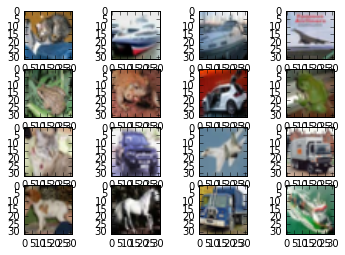

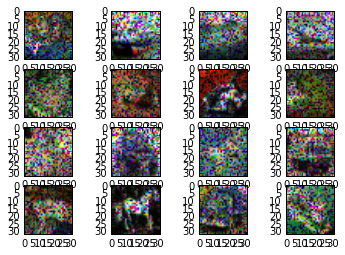

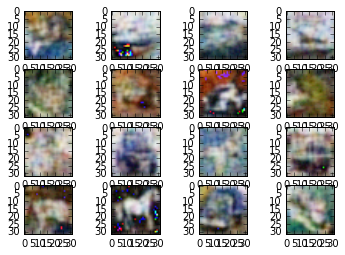

In [18]:
"""
Source Code for Homework 3 of ECBM E4040, Fall 2016, Columbia University

Instructor: Prof. Zoran Kostic

This code is based on
[1] http://deeplearning.net/tutorial/logreg.html
[2] http://deeplearning.net/tutorial/mlp.html
[3] http://deeplearning.net/tutorial/lenet.html
"""
from __future__ import print_function
import timeit
import inspect
import sys
import scipy 
import numpy

import theano
import theano.tensor as T
from theano import pp

from theano.tensor.nnet import conv
from theano.tensor.nnet import conv2d
#from theano.tensor.nnet import relu
from theano.tensor.signal import pool
from theano.tensor.signal import downsample
from hw3_utils import load_data
from hw3_utils import load_data_augmentation
from hw3_utils import shared_dataset

import pickle

import matplotlib.pyplot as plt
import random
%matplotlib inline

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).
        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

#Problem 1
#Implement the convolutional neural network architecture depicted in HW3 problem 1
#Reference code can be found in http://deeplearning.net/tutorial/code/convolutional_mlp.py

class LeNetConvPoolLayer(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
            """
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """

            assert image_shape[1] == filter_shape[1]
            self.input = input

            # there are "num input feature maps * filter height * filter width"
            # inputs to each hidden unit
            fan_in = numpy.prod(filter_shape[1:])
            # each unit in the lower layer receives a gradient from:
            # "num output feature maps * filter height * filter width" /
            #   pooling size
            fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                       numpy.prod(poolsize))
            # initialize weights with random weights
            W_bound = numpy.sqrt(6. / (fan_in + fan_out))
            self.W = theano.shared(
                numpy.asarray(
                    rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

            # the bias is a 1D tensor -- one bias per output feature map
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
            self.b = theano.shared(value=b_values, borrow=True)

            # convolve input feature maps with filters
            conv_out = conv2d(
                input=input,
                filters=self.W,
                filter_shape=filter_shape,
                input_shape=image_shape
            )

            # pool each feature map individually, using maxpooling
            pooled_out = pool.pool_2d(
                input=conv_out,
                ds=poolsize,
                ignore_border=True
            )

            # add the bias term. Since the bias is a vector (1D array), we first
            # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
            # thus be broadcasted across mini-batches and feature map
            # width & height
            self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

            # store parameters of this layer
            self.params = [self.W, self.b]

            # keep track of model input
            self.input = input

def train_nn(train_model, validate_model, test_model,
                n_train_batches, n_valid_batches, n_test_batches, n_epochs,
                verbose = True):
        """
        Wrapper function for training and test THEANO model

        :type train_model: Theano.function
        :param train_model:

        :type validate_model: Theano.function
        :param validate_model:

        :type test_model: Theano.function
        :param test_model:

        :type n_train_batches: int
        :param n_train_batches: number of training batches

        :type n_valid_batches: int
        :param n_valid_batches: number of validation batches

        :type n_test_batches: int
        :param n_test_batches: number of testing batches

        :type n_epochs: int
        :param n_epochs: maximal number of epochs to run the optimizer

        :type verbose: boolean
        :param verbose: to print out epoch summary or not to

        """
        
        
        print ('*************** Training ********************')
        # early-stopping parameters
        patience = 100000  # look as this many examples regardless
        patience_increase = 2  # wait this much longer when a new best is
                               # found
        improvement_threshold = 0.85  # a relative improvement of this much is
                                       # considered significant
        validation_frequency = min(n_train_batches, patience // 2)
                                      # go through this many
                                      # minibatche before checking the network
                                      # on the validation set; in this case we
                                      # check every epoch

        best_validation_loss = numpy.inf
        best_iter = 0
        test_score = 0.
        start_time = timeit.default_timer()

        epoch = 0
        done_looping = False

        while (epoch < n_epochs) and (not done_looping):
            epoch = epoch + 1
            for minibatch_index in range(n_train_batches):

                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter % 100 == 0) and verbose:
                    print('training @ iter = ', iter)
                cost_ij = train_model(minibatch_index)

                if (iter + 1) % validation_frequency == 0:

                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i
                                         in range(n_valid_batches)]
                    print 
                    this_validation_loss = numpy.mean(validation_losses)

                    if verbose:
                        print('epoch %i, minibatch %i/%i, validation MSE %f %%' %
                            (epoch,
                             minibatch_index + 1,
                             n_train_batches,
                             this_validation_loss))

                    # if we got the best validation score until now
                    if this_validation_loss <= best_validation_loss:

                        #improve patience if loss improvement is good enough
                        if this_validation_loss <= best_validation_loss *  \
                           improvement_threshold:
                            patience = max(patience, iter * patience_increase)

                        # save best validation score and iteration number
                        best_validation_loss = this_validation_loss
                        best_iter = iter                        

                if patience <= iter:
                    done_looping = True
                    break

        end_time = timeit.default_timer()

        # Retrieve the name of function who invokes train_nn() (caller's name)
        curframe = inspect.currentframe()
        calframe = inspect.getouterframes(curframe, 2)

        # Print out summary
        print('Optimization complete.')
        print(('The training process for function ' +
               calframe[1][3] +
               ' ran for %.2fm' % ((end_time - start_time) / 60.)), file=sys.stderr)
        
        return test_model(1)


    
#Problem 3 
#Implement a convolutional neural network to achieve at least 80% testing accuracy on CIFAR-dataset '''

def drop(input, p=0.5): 
    """
    :type input: numpy.array
    :param input: layer or weight matrix on which dropout is applied
    
    :type p: float or double between 0. and 1. 
    :param p: p probability of NOT dropping out a unit, therefore (1.-p) is the drop rate.
    
    """            
    rng = numpy.random.RandomState(1234)
    srng = T.shared_randomstreams.RandomStreams(rng.randint(999999))
    mask = srng.binomial(n=1, p=p, size=input.shape, dtype=theano.config.floatX)
    return input * mask

def drop_not_shared(input, p=0.5): 
    """
    :type input: numpy.array
    :param input: layer or weight matrix on which dropout is applied
    
    :type p: float or double between 0. and 1. 
    :param p: p probability of NOT dropping out a unit, therefore (1.-p) is the drop rate.
    
    """            
    rng = numpy.random.RandomState(1234)
    #srng = T.raw_random.RandomStreamsBase()
    mask = numpy.random.binomial(n=1, p=p, size=input.shape)
    #mask = srng.binomial(n=1, p=p, size=input.shape, dtype=theano.config.floatX)
    return input * mask

def momentum(cost, params, learning_rate, momentum):
    grads = theano.grad(cost, params)
    updates = []
    for p, g in zip(params, grads):
        mparam_i = theano.shared(numpy.zeros(p.get_value().shape, dtype=theano.config.floatX))
        v = momentum * mparam_i - learning_rate * g
        updates.append((mparam_i, v))
        updates.append((p, p + v))
    return updates


class DropoutHiddenLayer(object):
    def __init__(self, rng, is_train, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh, p=0.5):
        
        """
        Hidden unit activation is given by: activation(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights
        
        :type is_train: theano.iscalar   
        :param is_train: indicator pseudo-boolean (int) for switching between training and prediction

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
                           
        :type p: float or double
        :param p: probability of NOT dropping out a unit   
        """
        self.input = input

        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        
        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        
        output = activation(lin_output)
        
        # multiply output and drop -> in an approximation the scaling effects cancel out 
        train_output = drop(output,p)
        
        #is_train is a pseudo boolean theano variable for switching between training and prediction 
        self.output = T.switch(T.neq(is_train, 0), train_output, p*output)
        
        # parameters of the model
        self.params = [self.W, self.b]
        
class LeNetConvPoolDropoutLayer(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, is_train, filter_shape, image_shape, p=0.2, poolsize=(2, 2)):
            """ 
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """

            assert image_shape[1] == filter_shape[1]
            self.input = input

            # there are "num input feature maps * filter height * filter width"
            # inputs to each hidden unit
            fan_in = numpy.prod(filter_shape[1:])
            # each unit in the lower layer receives a gradient from:
            # "num output feature maps * filter height * filter width" /
            #   pooling size
            fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                       numpy.prod(poolsize))
            # initialize weights with random weights
            W_bound = numpy.sqrt(6. / (fan_in + fan_out))
            self.W = theano.shared(
                numpy.asarray(
                    rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

            # the bias is a 1D tensor -- one bias per output feature map
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
            self.b = theano.shared(value=b_values, borrow=True)

            # convolve input feature maps with filters
            conv_out = conv2d(
                input=input,
                filters=self.W,
                filter_shape=filter_shape,
                input_shape=image_shape
            )
            
            # pool each feature map individually, using maxpooling
            pooled_out = pool.pool_2d(
                input=conv_out,
                ds=poolsize,
                ignore_border=True
            )

            # add the bias term. Since the bias is a vector (1D array), we first
            # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
            # thus be broadcasted across mini-batches and feature map
            # width & height
            
            output = T.nnet.relu(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
            train_output = drop(output,p)
        
            #is_train is a pseudo boolean theano variable for switching between training and prediction 
            self.output = T.switch(T.neq(is_train, 0), train_output, p*output)

            # store parameters of this layer
            self.params = [self.W, self.b]

            # keep track of model input
            self.input = input



'''
#Problem4
#Implement the convolutional neural network depicted in problem4 
def MY_CNN():
'''


    
#MY_lenet()

class LeNetConvLayer(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, filter_shape, image_shape):
            """
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """

            assert image_shape[1] == filter_shape[1]
            self.input = input

            # there are "num input feature maps * filter height * filter width"
            # inputs to each hidden unit
            fan_in = numpy.prod(filter_shape[1:])
            # each unit in the lower layer receives a gradient from:
            # "num output feature maps * filter height * filter width" /
            #   pooling size
            fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) )
            # initialize weights with random weights
            W_bound = numpy.sqrt(6. / (fan_in + fan_out))
            self.W = theano.shared(
                numpy.asarray(
                    rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

            # the bias is a 1D tensor -- one bias per output feature map
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
            self.b = theano.shared(value=b_values, borrow=True)

            # convolve input feature maps with filters
            conv_out = conv2d(
                input=input,
                filters=self.W,
                filter_shape=filter_shape,
                input_shape=image_shape,
                border_mode = 'half'
            )

            # add the bias term. Since the bias is a vector (1D array), we first
            # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
            # thus be broadcasted across mini-batches and feature map
            # width & height
            self.output = T.tanh(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))

            # store parameters of this layer
            self.params = [self.W, self.b]

            # keep track of model input
            self.input = input

            
        

class LeNetPoolLayer(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, image_shape, poolsize=(2, 2)):
            """
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """

            self.input = input
            
            # pool each feature map individually, using maxpooling
            pooled_out = pool.max_pool_2d_same_size(
                input=input,
                patch_size=poolsize
            )

            self.output = pooled_out
            # store parameters of this layer

            # keep track of model input
            self.input = input

            
class LeNetUpSamplingLayer(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
            """
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """
            
            assert image_shape[1] == filter_shape[1]
            self.input = input

            # there are "num input feature maps * filter height * filter width"
            # inputs to each hidden unit
            fan_in = numpy.prod(filter_shape[1:])
            # each unit in the lower layer receives a gradient from:
            # "num output feature maps * filter height * filter width" /
            #   pooling size
            fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                       numpy.prod(poolsize))
            # initialize weights with random weights
            W_bound = numpy.sqrt(6. / (fan_in + fan_out))
            self.W = theano.shared(
                numpy.asarray(
                    rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

            # the bias is a 1D tensor -- one bias per output feature map
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
            self.b = theano.shared(value=b_values, borrow=True)

            # convolve input feature maps with filters
            deconv_op = T.nnet.abstract_conv.conv2d_grad_wrt_inputs(input, filters=self.W, input_shape = image_shape, 
                                               border_mode='half',   
                                               subsample=(1, 1), filter_flip=True)

            # pool each feature map individually, using maxpooling
            pooled_out = pool.max_pool_2d_same_size(
                input=deconv_op,
                patch_size=poolsize
            )

            # add the bias term. Since the bias is a vector (1D array), we first
            # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
            # thus be broadcasted across mini-batches and feature map
            # width & height
            self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

            # store parameters of this layer
            self.params = [self.W, self.b]

            # keep track of model input
            self.input = input


def depool(X, factor=1):
    """ 
    luke perforated upsample 
    http://www.brml.org/uploads/tx_sibibtex/281.pdf 
    """
    output_shape = [
        X.shape[1],
        X.shape[2]*factor,
        X.shape[3]*factor
    ]
    stride = X.shape[2]
    offset = X.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor
 
    upsamp_matrix = T.zeros((in_dim, out_dim))
    rows = T.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = T.set_subtensor(upsamp_matrix[rows, cols], 1.)
 
    flat = T.reshape(X, (X.shape[0], output_shape[0], X.shape[2] * X.shape[3]))
 
    up_flat = T.dot(flat, upsamp_matrix)
    upsamp = T.reshape(up_flat, (X.shape[0], output_shape[0], output_shape[1], output_shape[2]))
 
    return upsamp

class LeNetConvPoolLayer2(object):
        """Pool Layer of a convolutional network """

        def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
            """
            Allocate a LeNetConvPoolLayer with shared variable internal parameters.

            :type rng: numpy.random.RandomState
            :param rng: a random number generator used to initialize weights

            :type input: theano.tensor.dtensor4
            :param input: symbolic image tensor, of shape image_shape

            :type filter_shape: tuple or list of length 4
            :param filter_shape: (number of filters, num input feature maps,
                                  filter height, filter width)

            :type image_shape: tuple or list of length 4
            :param image_shape: (batch size, num input feature maps,
                                 image height, image width)

            :type poolsize: tuple or list of length 2
            :param poolsize: the downsampling (pooling) factor (#rows, #cols)
            """

            assert image_shape[1] == filter_shape[1]
            self.input = input

            # there are "num input feature maps * filter height * filter width"
            # inputs to each hidden unit
            fan_in = numpy.prod(filter_shape[1:])
            # each unit in the lower layer receives a gradient from:
            # "num output feature maps * filter height * filter width" /
            #   pooling size
            fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                       numpy.prod(poolsize))
            # initialize weights with random weights
            W_bound = numpy.sqrt(6. / (fan_in + fan_out))
            self.W = theano.shared(
                numpy.asarray(
                    rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

            # the bias is a 1D tensor -- one bias per output feature map
            b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
            self.b = theano.shared(value=b_values, borrow=True)

            # convolve input feature maps with filters
            conv_out = conv2d(
                input=input,
                filters=self.W,
                filter_shape=filter_shape,
                input_shape=image_shape,
                border_mode = 'half'
            )

            # pool each feature map individually, using maxpooling
            pooled_out = pool.max_pool_2d_same_size(
                input=conv_out,
                patch_size=poolsize
            )

            # add the bias term. Since the bias is a vector (1D array), we first
            # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
            # thus be broadcasted across mini-batches and feature map
            # width & height
            self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

            # store parameters of this layer
            self.params = [self.W, self.b]

            # keep track of model input
            self.input = input


class MSE(object):
    def __init__(self, input):
        self.p_y_given_x = input
        self.input = input
        self.y_pred = self.input
    def mse(self, y):
        return T.mean((self.p_y_given_x-y)**2)

    
def construct_model_4(dataset='cifar-10-matlab.tar.gz',
                        learning_rate=0.1, 
                        batch_size=128,
                        n_epochs=1):
        
        rng = numpy.random.RandomState(23455)
        print ('loading started')
        ds_rate=None
        datasets = load_data(ds_rate=ds_rate,theano_shared=True)
        #datasets = load_data(ds_rate=ds_rate,theano_shared=True)
        
        train_set_x, train_set_y = datasets[0]
        valid_set_x, valid_set_y = datasets[1]
        datasets = load_data(ds_rate=ds_rate,theano_shared=False)
        test_set_x, test_set_y = datasets[2]
        test_set_x = T.cast(test_set_x, 'float32')
        new_test_data = test_set_x[:128], T.cast(test_set_y[:128], 'int32')
        print('Current training data size is %i'%train_set_x.get_value(borrow=True).shape[0])
        print('Current validation data size is %i'%valid_set_x.get_value(borrow=True).shape[0])
        #print('Current test data size is %i'%new_test_data[0].get_value(borrow=True).shape[0])

        # compute number of minibatches for training, validation and testing
        
        n_train_batches = train_set_x.get_value(borrow=True).shape[0]
        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        #n_test_batches = new_test_data[0].get_value(borrow=True).shape[0]
        n_train_batches //= batch_size
        n_valid_batches //= batch_size
        #n_test_batches //= batch_size
        n_test_batches = 1
        print ('loading complete')
        
        
        # allocate symbolic variables for the data
        index = T.lscalar()  # index to a [mini]batch

        # start-snippet-1
        x = T.matrix('x')   # the data is presented as rasterized images
        y = T.ivector('y')  # the labels are presented as 1D vector of
                            # [int] labels

        ######################
        # BUILD ACTUAL MODEL #
        ######################
        print('... building the model')

        layer0_input = x.reshape((batch_size, 3, 32, 32))
        
        layer0 = drop(
            layer0_input,
            0.7
        )
        
        layer1 = LeNetConvLayer(
            rng,
            input=layer0,
            image_shape=(batch_size, 3, 
                         32, 
                         32),
            filter_shape=(64, 3, 3, 3)
            #poolsize=pool_size[1]
        )
        
        layer2 = LeNetConvLayer(
            rng,
            input=layer1.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(64, 64, 3, 3)
            #poolsize=pool_size[1]
        )
        
        output_1 = layer2.output
        
        layer3 = LeNetPoolLayer(
            rng,
            input=layer2.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            #filter_shape=(64, 64, 3, 3)
            poolsize=(2,2)
        )
        pp(layer3.output)
        
        layer4 = LeNetConvLayer(
            rng,
            input=layer3.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(128, 64, 3, 3)
            #poolsize=pool_size[1]
        )
        
        layer5 = LeNetConvLayer(
            rng,
            input=layer4.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3)
            #poolsize=pool_size[1]
        )
        
        output_2 = layer5.output
        pp(output_2)
        
        layer6 = LeNetPoolLayer(
            rng,
            input=layer5.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            #filter_shape=(64, 64, 3, 3)
            poolsize=(2,2)
        )
        
        layer7 = LeNetConvLayer(
            rng,
            input=layer6.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(256, 128, 3, 3)
            #poolsize=pool_size[1]
        )
        
        layer8 = LeNetUpSamplingLayer(
            rng,
            input=layer7.output,
            image_shape=(batch_size, 256, 
                         32, 
                         32),
            filter_shape=(256, 256, 3, 3),
            poolsize=(2,2)
        )

        #layer8 = depool (layer7.output)
        
        layer9 = LeNetConvLayer(
            rng,
            input=layer8.output,
            image_shape=(batch_size, 256, 
                         32, 
                         32),
            filter_shape=(128, 256, 3, 3)
            #poolsize=pool_size[1]
        )
        
        layer10 = LeNetConvLayer(
            rng,
            input=layer9.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3)
            #poolsize=pool_size[1]
        )
        
        output_3 = layer10.output
        
        output_4 = output_2 + output_3
        #output_4 = numpy.sum(output_4, axis=0)
        

        #output_4 = output_3
    
        #layer11 = depool (output_4)
    
        layer11 = LeNetUpSamplingLayer(
            rng,
            input=output_4,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3),
            poolsize=(2,2)
        )
        
        layer12 = LeNetConvLayer(
            rng,
            input=layer11.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(64, 128, 3, 3)
            #poolsize=pool_size[1]
        )
        
        layer13 = LeNetConvLayer(
            rng,
            input=layer12.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(64, 64, 3, 3)
            #poolsize=pool_size[1]
        )
        
        output_5 = layer13.output
        
        output_6 = output_5 + output_1
        #output_6 = numpy.sum(output_6, axis=0)
        
        layer14 = LeNetConvLayer(
            rng,
            input=output_6,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(3, 64, 3, 3)
            #poolsize=pool_size[1]
        )
        '''
        pool_size = [(2,2),(1,1)]
        layer1 = LeNetConvPoolLayer2(
            rng,
            input=layer0,
            image_shape=(batch_size, 3, 
                         32, 
                         32),
            filter_shape=(64, 3, 3, 3),
            poolsize=pool_size[1]
        )
        
        layer2 = LeNetConvPoolLayer2(
            rng,
            input=layer1.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(64, 64, 3, 3),
            poolsize=pool_size[1]
        )
        
        output_1 = layer2.output
        
        
        layer3 = LeNetConvPoolLayer2(
            rng,
            input=layer2.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(64, 64, 1, 1),
            poolsize=(2,2)
        )
        pp(layer3.output)
        
        layer4 = LeNetConvPoolLayer2(
            rng,
            input=layer3.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(128, 64, 3, 3),
            poolsize=pool_size[1]
        )
        
        layer5 = LeNetConvPoolLayer2(
            rng,
            input=layer4.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3),
            poolsize=pool_size[1]
        )
        
        output_2 = layer5.output
        pp(output_2)
        
        layer6 = LeNetConvPoolLayer2(
            rng,
            input=layer5.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 1, 1),
            poolsize=(2,2)
        )
        
        layer7 = LeNetConvPoolLayer2(
            rng,
            input=layer6.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(256, 128, 3, 3),
            poolsize=pool_size[1]
        )
        
        layer8 = LeNetUpSamplingLayer(
            rng,
            input=layer7.output,
            image_shape=(batch_size, 256, 
                         32, 
                         32),
            filter_shape=(256, 256, 3, 3),
            poolsize=(1,1)
        )

        
        layer9 = LeNetConvPoolLayer2(
            rng,
            input=layer8.output,
            image_shape=(batch_size, 256, 
                         32, 
                         32),
            filter_shape=(128, 256, 3, 3),
            poolsize=pool_size[1]
        )
        
        layer10 = LeNetConvPoolLayer2(
            rng,
            input=layer9.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3),
            poolsize=pool_size[1]
        )
        
        output_3 = layer10.output
        
        output_4 = output_2 + output_3

        
        layer11 = LeNetUpSamplingLayer(
            rng,
            input=output_4,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(128, 128, 3, 3),
            poolsize=(1,1)
        )
        
        layer12 = LeNetConvPoolLayer2(
            rng,
            input=layer11.output,
            image_shape=(batch_size, 128, 
                         32, 
                         32),
            filter_shape=(64, 128, 3, 3),
            poolsize=pool_size[1]
        )
        
        layer13 = LeNetConvPoolLayer2(
            rng,
            input=layer12.output,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(64, 64, 3, 3),
            poolsize=pool_size[1]
        )
        
        output_5 = layer13.output
        
        output_6 = output_5 + output_1
        #output_6 = numpy.sum(output_6, axis=0)
        
        layer14 = LeNetConvPoolLayer2(
            rng,
            input=output_6,
            image_shape=(batch_size, 64, 
                         32, 
                         32),
            filter_shape=(3, 64, 3, 3),
            poolsize=pool_size[1] )
            
        '''
        # the cost we minimize during training is the NLL of the model
        nimb = MSE(layer14.output)
        
        cost = nimb.mse(x.reshape((batch_size, 3, 32, 32)))
        

        # create a function to compute the mistakes that are made by the model
        '''test_model = theano.function(
            [index],
            on_unused_input='warn'
            #nimb.mse(x.reshape((batch_size, 3, 32, 32))),
            #givens={
                #x: test_set_x[index * batch_size: (index + 1) * batch_size],
                #y: test_set_y[index * batch_size: (index + 1) * batch_size]
                #x: T.cast(new_test_data[0], 'float32')
            #}
        )'''
        
        test_model = theano.function(
            [index],
            [x,layer0,layer14.output],
            givens={
                x: new_test_data[0]},
            on_unused_input='warn'
        )

        validate_model = theano.function(
            [index],
            cost,
            #[x,layer14.output],
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]
            },
            on_unused_input='warn'
        )

        # create a list of all model parameters to be fit by gradient descent
        #params = layer1.params +  layer2.params + layer3.params +  layer4.params + layer5.params + layer6.params + layer7.params + layer8.params + layer9.params + layer10.params + layer11.params + layer12.params+ layer13.params + layer14.params
        params = layer1.params +  layer2.params + layer4.params + layer5.params + layer7.params + layer8.params + layer9.params + layer10.params + layer11.params + layer12.params+ layer13.params + layer14.params

        # create a list of gradients for almodel parameters
        #grads = T.grad(cost, params)

        # train_model is a function that updates the model parameters by
        # SGD Since this model has many parameters, it would be tedious to
        # manually create an update rule for each model parameter. We thus
        # create the updates list by automatically looping over all
        # (params[i], grads[i]) pairs.
        updates = momentum(cost, params, learning_rate, momentum=0.9)

        train_model = theano.function(
            [index],
            cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            },
            on_unused_input='warn'
        )
        print ('model built')
        predicted_values = train_nn(train_model, validate_model, test_model,
            n_train_batches, n_valid_batches, n_test_batches, n_epochs,
            verbose = True) 
        return predicted_values[0], predicted_values[1], predicted_values[2]
        
        
    
def predict_model(p,q,r):
        
        
        print('original images')
        #test_layer0_input = new_test_data[0].reshape((16, 3, 32, 32))
        f, axarr = plt.subplots(4,4)
        for i in range(4):
            for j in range(4):
                plt.axes(axarr[i,j])
                
                img = p[i*4+j].reshape((3,32,32)).transpose(1,2,0)
                plt.imshow(img) 
        
        #assert new_layer0 == layer0_input
        
        #print_images(new_layer0)
        #new_layer0 = numpy.ndarray(new_layer0)
        #print(new_layer0.get_value(borrow=True).shape)
        print('Dropped Out images')
        f, axarr = plt.subplots(4,4)
        
        for i in range(4):
            for j in range(4):
                plt.axes(axarr[i,j])
                img = q[i*4+j].reshape((3,32,32)).transpose(1,2,0)
                plt.imshow(img)
        
        
        print('Recreated Images')
        
        f, axarr = plt.subplots(4,4)
        
        for i in range(4):
            for j in range(4):
                plt.axes(axarr[i,j])
                img = r[i*4+j].transpose(1,2,0)
                plt.imshow(img) 
            
#Problem4
#Implement the convolutional neural network depicted in problem4 
def MY_CNN():
    p, q, r = construct_model_4()
    predict_model(p,q,r)
    
    

MY_CNN()